In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
import warnings
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
%matplotlib inline
warnings.filterwarnings('ignore') # Suppress warnings
from matplotlib.pyplot import figure

In [ ]:
#LSTM 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
from tensorflow.keras.layers import Dense, Activation, LSTM, Conv1D, TimeDistributed, MaxPooling1D, Flatten
## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.2 MB/s 


In [ ]:
# Data cleaning section
shenzhen = pd.read_csv("shenzhen_cleaned_data.csv")
shenzhen['acid_feed'] = shenzhen['1_acidification_hydrolysis_tank_feed_'] \
                                             + shenzhen['2_acidification_hydrolysis_tank_feed_']
shenzhen['acid_discharge']  = shenzhen['1_acidification_hydrolysis_tank_discharge_']\
                                             + shenzhen['2_acidification_hydrolysis_tank_discharge_']
shenzhen['anaerobic_feed'] = shenzhen['1_Anaerobic_tank_slurry_feed_'] \
                                             + shenzhen['2_Anaerobic_tank_slurry_feed_']
shenzhen['anaerobic_cumuprod'] = shenzhen['1_Anaerobic_tank_biogas_cumulative_production_'] \
                                             + shenzhen['2_anaerobic_tank_biogas_cumulative_production_']
shenzhen['anaerobic_dailyoutput'] = shenzhen['1_anaerobic_tank_biogas_daily_output_'] \
                                             + shenzhen['2_anaerobic_tank_biogas_daily_output_']
shenzhen = shenzhen.drop(['1_acidification_hydrolysis_tank_feed_','2_acidification_hydrolysis_tank_feed_',\
               '1_acidification_hydrolysis_tank_discharge_','2_acidification_hydrolysis_tank_discharge_',\
               '1_Anaerobic_tank_slurry_feed_','2_Anaerobic_tank_slurry_feed_',\
               '1_Anaerobic_tank_biogas_cumulative_production_','2_anaerobic_tank_biogas_cumulative_production_',\
               '1_anaerobic_tank_biogas_daily_output_','2_anaerobic_tank_biogas_daily_output_'],axis=1)

shenzhen.head()

,Unnamed: 0,Kitchen_waste_,Fruit_and_vegetable_waste_,Bread_Paste_,Waste_oil_,Total_Waste_,Diesel_waste_water_,Flour_and_waste_oil_,Kitchen_waste_paste_,acid_feed,acid_discharge,anaerobic_feed,anaerobic_cumuprod,anaerobic_dailyoutput
0,0,92.03,0.0,7.95,13.54,99.98,54.0,17.0,167.0,0.0,0.0,130.0,340453.0,7919.0
1,1,78.43,0.0,13.30,16.10,91.73,36.0,8.0,100.0,0.0,0.0,170.0,343154.0,2701.0
2,2,81.84,0.0,8.35,6.60,90.19,22.0,34.0,120.0,0.0,0.0,150.0,353361.0,10207.0
3,3,81.05,0.0,9.10,17.48,90.15,22.0,20.0,92.0,0.0,0.0,160.0,363943.0,10582.0
4,4,36.86,0.0,9.40,12.47,46.26,44.0,35.0,122.0,0.0,0.0,160.0,372971.0,9028.0


In [ ]:
shenzhen.acid_feed = shenzhen.acid_feed.shift(-15)
shenzhen.acid_discharge = shenzhen.acid_discharge.shift(-15)
shenzhen.anaerobic_feed = shenzhen.anaerobic_feed.shift(-15)
shenzhen.anaerobic_cumuprod = shenzhen.anaerobic_cumuprod.shift(-15)
shenzhen.anaerobic_dailyoutput = shenzhen.anaerobic_dailyoutput.shift(-15)
shenzhen = shenzhen.drop(['Unnamed: 0'], axis=1)
shenzhen = shenzhen[:-15]
shenzhen.tail()

,Kitchen_waste_,Fruit_and_vegetable_waste_,Bread_Paste_,Waste_oil_,Total_Waste_,Diesel_waste_water_,Flour_and_waste_oil_,Kitchen_waste_paste_,acid_feed,acid_discharge,anaerobic_feed,anaerobic_cumuprod,anaerobic_dailyoutput
436,150.03,25.45,0.0,6.49,175.48,44.0,0.0,151.0,0.0,200.0,200.0,3091363.0,7526.0
437,144.28,49.36,0.0,10.04,193.64,44.0,0.0,145.0,0.0,210.0,210.0,3098699.0,7336.0
438,98.96,32.86,0.0,9.79,131.82,0.0,0.0,101.0,0.0,230.0,230.0,3105678.0,6979.0
439,86.92,32.11,0.0,11.71,119.03,44.0,0.0,89.0,0.0,220.0,220.0,3112064.0,6626.0
440,158.93,33.02,0.0,9.10,191.95,0.0,0.0,160.0,0.0,230.0,230.0,3119057.0,6993.0


In [ ]:
shenzhen_date = pd.read_csv("Sheet 2-Table 1.csv", 
                 parse_dates={'dt' : ['Year', 'Month','Day']})
shenzhen_date=shenzhen_date.drop(['Month #','Day #'],axis=1)
shenzhen_date.tail()

,dt
449,2015-07-24
450,2015-07-25
451,2015-07-26
452,2015-07-27
453,2015-07-28


In [ ]:
#### merging 
hainan= pd.merge(shenzhen_date, shenzhen, how="outer", left_index=True,right_index=True)
hainan=hainan.dropna()
hainan.tail()

,dt,Kitchen_waste_,Fruit_and_vegetable_waste_,Bread_Paste_,Waste_oil_,Total_Waste_,Diesel_waste_water_,Flour_and_waste_oil_,Kitchen_waste_paste_,acid_feed,acid_discharge,anaerobic_feed,anaerobic_cumuprod,anaerobic_dailyoutput
436,2015-07-11,150.03,25.45,0.0,6.49,175.48,44.0,0.0,151.0,0.0,200.0,200.0,3091363.0,7526.0
437,2015-07-12,144.28,49.36,0.0,10.04,193.64,44.0,0.0,145.0,0.0,210.0,210.0,3098699.0,7336.0
438,2015-07-13,98.96,32.86,0.0,9.79,131.82,0.0,0.0,101.0,0.0,230.0,230.0,3105678.0,6979.0
439,2015-07-14,86.92,32.11,0.0,11.71,119.03,44.0,0.0,89.0,0.0,220.0,220.0,3112064.0,6626.0
440,2015-07-15,158.93,33.02,0.0,9.10,191.95,0.0,0.0,160.0,0.0,230.0,230.0,3119057.0,6993.0


In [ ]:
hainan.columns = hainan.columns.str.replace('  ', '_')
hainan.columns = hainan.columns.str.replace(' ', '_')
hainan.columns = hainan.columns.str.replace('(', '')
hainan.columns = hainan.columns.str.replace('（', '')
hainan.columns = hainan.columns.str.replace(')', '')

#d = { 'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,
#     'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12 }

#hainan.Month = hainan.Month.map(d)

In [ ]:
hainan=hainan.set_index('dt')
hainan.tail()

,Kitchen_waste_,Fruit_and_vegetable_waste_,Bread_Paste_,Waste_oil_,Total_Waste_,Diesel_waste_water_,Flour_and_waste_oil_,Kitchen_waste_paste_,acid_feed,acid_discharge,anaerobic_feed,anaerobic_cumuprod,anaerobic_dailyoutput
dt,,,,,,,,,,,,,
2015-07-11,150.03,25.45,0.0,6.49,175.48,44.0,0.0,151.0,0.0,200.0,200.0,3091363.0,7526.0
2015-07-12,144.28,49.36,0.0,10.04,193.64,44.0,0.0,145.0,0.0,210.0,210.0,3098699.0,7336.0
2015-07-13,98.96,32.86,0.0,9.79,131.82,0.0,0.0,101.0,0.0,230.0,230.0,3105678.0,6979.0
2015-07-14,86.92,32.11,0.0,11.71,119.03,44.0,0.0,89.0,0.0,220.0,220.0,3112064.0,6626.0
2015-07-15,158.93,33.02,0.0,9.10,191.95,0.0,0.0,160.0,0.0,230.0,230.0,3119057.0,6993.0


In [ ]:
# ML algorithms Comparision 
from pandas import DataFrame
trans = MinMaxScaler()
value=shenzhen.values
df_shenzhen = trans.fit_transform(value)
df_shenzhen = DataFrame(df_shenzhen)
df_shenzhen=df_shenzhen.dropna()
#creating independent variables as X and target/dependent variable as y
y= df_shenzhen.pop(12)
X= df_shenzhen
#Let’s split X and y using Train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state= 42)
#get shape of train and test data
print("train data size:",X_train.shape)
print("test data size:",X_test.shape)
## seperation
#X, y = df_shenzhen.drop([12]), df_shenzhen[12]
# report pipeline performance
#train_Xt, train_yt = scaled_shenzhen[:, :-1], train[:, -1]
#X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state= 42)



train data size: (352, 12)
test data size: (89, 12)


Streaming output truncated to the last 5000 lines.
14:	learn: 0.1657787	total: 38.5ms	remaining: 2.53s
15:	learn: 0.1642441	total: 40.8ms	remaining: 2.51s
16:	learn: 0.1632217	total: 43.3ms	remaining: 2.5s
17:	learn: 0.1617874	total: 45.9ms	remaining: 2.5s
18:	learn: 0.1608117	total: 48.5ms	remaining: 2.51s
19:	learn: 0.1597853	total: 51ms	remaining: 2.5s
20:	learn: 0.1590116	total: 53.9ms	remaining: 2.51s
21:	learn: 0.1577551	total: 56.4ms	remaining: 2.51s
22:	learn: 0.1565029	total: 58.8ms	remaining: 2.5s
23:	learn: 0.1557747	total: 61.2ms	remaining: 2.49s
24:	learn: 0.1550096	total: 63.7ms	remaining: 2.48s
25:	learn: 0.1541181	total: 66.2ms	remaining: 2.48s
26:	learn: 0.1533877	total: 68.7ms	remaining: 2.48s
27:	learn: 0.1528220	total: 71.5ms	remaining: 2.48s
28:	learn: 0.1522668	total: 74.5ms	remaining: 2.5s
29:	learn: 0.1509789	total: 77.5ms	remaining: 2.5s
30:	learn: 0.1497833	total: 80.1ms	remaining: 2.5s
31:	learn: 0.1490623	total: 82.6ms	remaining: 2.5s
32:	learn: 0.1482346	to

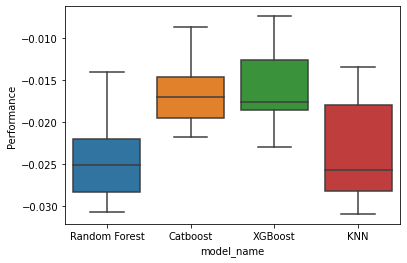

In [ ]:
# Showing the performance of model with 10-fold CV BOXPLOT

# Create list of models to be tested: Random Forest, Catboost, XGBoost & KNN

models = [(RandomForestRegressor(n_estimators = 120, max_depth=3, random_state=0)), 
          CatBoostRegressor(), XGBRegressor(n_estimators = 120, max_depth=3, random_state=0), 
                              KNeighborsRegressor()]

# number of folds (10-fold cross validation performed for each model)
CV = 10

# create blank dataframe with an index equal to the number of CV folds * number of models tested
cv_words = pd.DataFrame(index=range(CV * len(models)))

#create an empty list, which will be populated with the accuracies of each model at each fold
entries = []

# list of the names of the models tested
names = ["Random Forest", "Catboost", "XGBoost", "KNN"]
# populate the dataframe 'cv_words' with the fold and performance at each fold
i = 0
for model in models:
    #model_name = #model.__class__.__name__
    model_name = names[i]
    # model => the model that will be used to fit the data
    # x_train_words_sm => x training data after oversampling (unigrams)
    # y_train_sm => y training data after oversampling (event_id)
    # scoring => the type of score you want the function 'cross_val_score' to return
    # cv = number of folds you want to be performed with cross-validation
    accuracies = cross_val_score(model, X_train, y_train, scoring ='neg_mean_squared_error', cv=CV)
    for fold_idx, accuracy in enumerate(performance):
        entries.append((model_name, fold_idx, accuracy))
        cv_words = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'Performance'])
    i = i + 1

# plot the results of each model on a single box plot    
box_plot = sns.boxplot(x='model_name', y='Performance', data=cv_words)
fig_words = box_words.get_figure()
fig_words.savefig('boxplot_ML.png')

In [ ]:
model = CatBoostRegressor()
# Fit model 
model.fit( X_train, y_train,
               eval_set=(X_test, y_test))
y_pred=model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(y_test, y_pred)
print('Test MSE: %.3f' % mse)
MAE = mae(y_test, y_pred)
print('Test MAE: %.3f' % MAE)
MAPE= mean_absolute_percentage_error(y_test, y_pred)
print('Test MAPE: %.1f' % MAPE)

Learning rate set to 0.043222
0:	learn: 0.1845856	test: 0.1798144	best: 0.1798144 (0)	total: 12ms	remaining: 12s
1:	learn: 0.1825275	test: 0.1786255	best: 0.1786255 (1)	total: 21ms	remaining: 10.5s
2:	learn: 0.1803608	test: 0.1772121	best: 0.1772121 (2)	total: 25.8ms	remaining: 8.58s
3:	learn: 0.1785317	test: 0.1757818	best: 0.1757818 (3)	total: 29.4ms	remaining: 7.33s
4:	learn: 0.1765902	test: 0.1746815	best: 0.1746815 (4)	total: 32.8ms	remaining: 6.52s
5:	learn: 0.1747338	test: 0.1735989	best: 0.1735989 (5)	total: 36.2ms	remaining: 6s
6:	learn: 0.1731480	test: 0.1724867	best: 0.1724867 (6)	total: 43.5ms	remaining: 6.17s
7:	learn: 0.1717395	test: 0.1718242	best: 0.1718242 (7)	total: 50.4ms	remaining: 6.25s
8:	learn: 0.1702908	test: 0.1708827	best: 0.1708827 (8)	total: 53.6ms	remaining: 5.91s
9:	learn: 0.1688678	test: 0.1699410	best: 0.1699410 (9)	total: 56.3ms	remaining: 5.58s
10:	learn: 0.1676912	test: 0.1693564	best: 0.1693564 (10)	total: 59.1ms	remaining: 5.31s
11:	learn: 0.1661188

Learning rate set to 0.035975
0:	learn: 0.1836297	total: 3.81ms	remaining: 3.81s
1:	learn: 0.1818759	total: 6.46ms	remaining: 3.22s
2:	learn: 0.1806923	total: 9.39ms	remaining: 3.12s
3:	learn: 0.1791763	total: 12.4ms	remaining: 3.09s
4:	learn: 0.1773995	total: 15.4ms	remaining: 3.06s
5:	learn: 0.1757107	total: 18.4ms	remaining: 3.04s
6:	learn: 0.1741477	total: 21.4ms	remaining: 3.04s
7:	learn: 0.1729726	total: 24.7ms	remaining: 3.06s
8:	learn: 0.1717117	total: 28.3ms	remaining: 3.11s
9:	learn: 0.1703488	total: 31.7ms	remaining: 3.14s
10:	learn: 0.1693513	total: 34.9ms	remaining: 3.14s
11:	learn: 0.1679908	total: 38.1ms	remaining: 3.14s
12:	learn: 0.1668324	total: 41.1ms	remaining: 3.12s
13:	learn: 0.1654986	total: 45.5ms	remaining: 3.2s
14:	learn: 0.1643961	total: 49ms	remaining: 3.21s
15:	learn: 0.1632787	total: 52.2ms	remaining: 3.21s
16:	learn: 0.1621284	total: 55.3ms	remaining: 3.2s
17:	learn: 0.1608835	total: 58.6ms	remaining: 3.2s
18:	learn: 0.1598343	total: 62ms	remaining: 3.2s


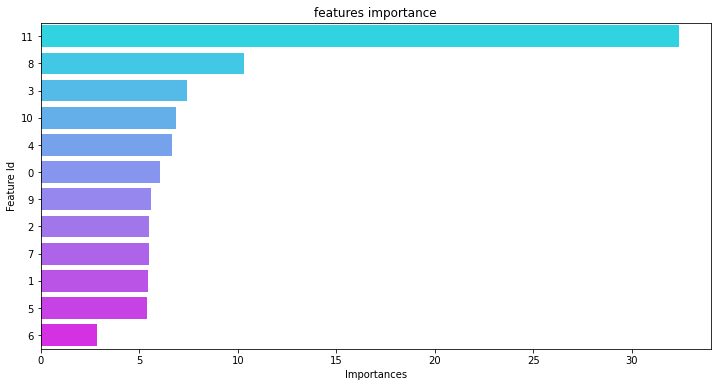

In [ ]:
#Feature selection with Catboost
model.fit( X, y)
# Create a dataframe of feature importance 
df_feature_importance_catboost = pd.DataFrame(model.get_feature_importance(prettified=True))
#plotting feature importance
plt.figure(figsize=(12, 6));
feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance_catboost,palette="cool");
plt.title('features importance');

In [ ]:
### Deep learning architectures
# LSTM 
# time series to supervised
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 


In [ ]:
## resampling of data over day
hainan_resample =hainan.resample('D').mean()
## * Note: I scale all features in range of [0,1].

values = hainan_resample.values 


## full data without resampling
#values = hainan.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict (feature selection)
reframed.drop(reframed.columns[[6,19,5,18,1,14,7,20,2,15,9,22]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var4(t-1)  var5(t-1)  var9(t-1)  var11(t-1)  var12(t-1)  \
1   0.458751   0.498895   0.390318   0.475352    0.483696    0.000000   
2   0.390958   0.593220   0.358110   0.320423    0.361413    0.003249   
3   0.407956   0.243183   0.352098   0.176056    0.375000    0.006430   
4   0.404018   0.644068   0.351942   0.334507    0.347826    0.009739   
5   0.183740   0.459469   0.180597   0.031690    0.347826    0.012658   

   var13(t-1)   var1(t)   var4(t)   var5(t)   var9(t)  var11(t)  var12(t)  \
1     0.74360  0.390958  0.593220  0.358110  0.320423  0.361413  0.003249   
2     0.68992  0.407956  0.243183  0.352098  0.176056  0.375000  0.006430   
3     0.67568  0.404018  0.644068  0.351942  0.334507  0.347826  0.009739   
4     0.70272  0.183740  0.459469  0.180597  0.031690  0.347826  0.012658   
5     0.61992  0.107572  0.436625  0.147492  0.190141  0.266304  0.015386   

   var13(t)  
1   0.68992  
2   0.67568  
3   0.70272  
4   0.61992  
5   0.57944  


In [ ]:
# split into train and test sets
values = reframed.values

n_train_time = 350
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(350, 1, 13) (350,) (90, 1, 13) (90,)


Epoch 1/100
7/7 - 3s - loss: 0.1961 - val_loss: 0.1101 - 3s/epoch - 367ms/step
Epoch 2/100
7/7 - 0s - loss: 0.0842 - val_loss: 0.0253 - 56ms/epoch - 8ms/step
Epoch 3/100
7/7 - 0s - loss: 0.0411 - val_loss: 0.0477 - 74ms/epoch - 11ms/step
Epoch 4/100
7/7 - 0s - loss: 0.0393 - val_loss: 0.0823 - 57ms/epoch - 8ms/step
Epoch 5/100
7/7 - 0s - loss: 0.0378 - val_loss: 0.0650 - 59ms/epoch - 8ms/step
Epoch 6/100
7/7 - 0s - loss: 0.0335 - val_loss: 0.0396 - 56ms/epoch - 8ms/step
Epoch 7/100
7/7 - 0s - loss: 0.0308 - val_loss: 0.0283 - 61ms/epoch - 9ms/step
Epoch 8/100
7/7 - 0s - loss: 0.0324 - val_loss: 0.0261 - 60ms/epoch - 9ms/step
Epoch 9/100
7/7 - 0s - loss: 0.0305 - val_loss: 0.0277 - 57ms/epoch - 8ms/step
Epoch 10/100
7/7 - 0s - loss: 0.0303 - val_loss: 0.0297 - 60ms/epoch - 9ms/step
Epoch 11/100
7/7 - 0s - loss: 0.0294 - val_loss: 0.0300 - 62ms/epoch - 9ms/step
Epoch 12/100
7/7 - 0s - loss: 0.0287 - val_loss: 0.0285 - 58ms/epoch - 8ms/step
Epoch 13/100
7/7 - 0s - loss: 0.0278 - val_loss:

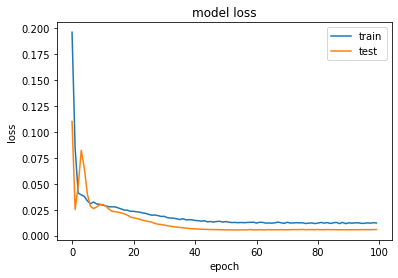

Test RMSE: 0.077
Test MSE: 0.006
Test MAE: 0.059


In [ ]:
#LSTM
model = Sequential()
model.add(LSTM(150, activation='tanh', input_shape=(train_X.shape[1], train_X.shape[2]))),

model.add(Dropout(0.25))

#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)

# calculate test errors: NRMSE,NMSE,NMAE
rmse = np.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(test_y, yhat)
print('Test MSE: %.3f' % mse)
MAE = mae(test_y, yhat)
print('Test MAE: %.3f' % MAE)


In [ ]:
# make a prediction
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
def descale(descaler, values):
    values_2d = np.array(test_y)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()
#yhat = model.predict(test_X)
prediction_descaled = descale(descaler, yhat)
test_X = test_X.reshape((test_X.shape[0], 13))
inv_yhat = np.concatenate((yhat, test_X[:, -13:]), axis=1)
# invert scaling for forecast
inv_yhat = descaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -13:]), axis=1)
inv_y = descaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


In [ ]:
# Descaled error 
#rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)
#mse = mean_squared_error(inv_y, inv_yhat)
#print('Test MSE: %.3f' % mse)
#MAE = mae(inv_y, inv_yhat)
#print('Test MAE: %.3f' % MAE)


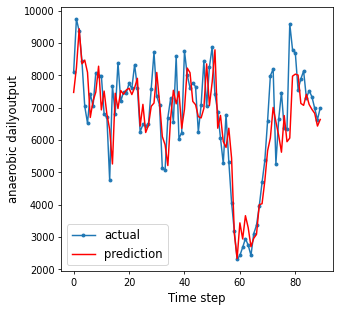

In [ ]:
# Prediction results visualization for LSTM
figure(figsize=(5, 5), dpi=70)
aa=[x for x in range(90)]
plt.plot(aa, inv_y[:90], marker='.', label="actual")
plt.plot(aa, inv_yhat[:90], 'r', label="prediction")
plt.ylabel('anaerobic dailyoutput', size=12)
plt.xlabel('Time step', size=12)
plt.legend(fontsize=12)
plt.show()

In [ ]:
#CNN-LSTM
subsequences = 1
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (350, 1, 13, 1)
Validation set shape (90, 1, 13, 1)


In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='ReLU'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, return_sequences=True,activation='tanh'))  # returns a sequence of vectors of dimension 32
model_cnn_lstm.add(LSTM(50,activation='sigmoid'))  # return a single vector of dimension 32
model_cnn_lstm.add(Dropout(0.25))
model_cnn_lstm.add(Dense(1,activation='linear'))
model_cnn_lstm.compile(loss='mse', optimizer='adam')
#cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, train_y, validation_data=(X_valid_series_sub, test_y), epochs=100, batch_size= 40, verbose=2,shuffle=False)
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, train_y, validation_data=(X_valid_series_sub, test_y), epochs=120, batch_size=45 ,verbose=2)

Epoch 1/120
8/8 - 4s - loss: 1.1071 - val_loss: 0.9500 - 4s/epoch - 545ms/step
Epoch 2/120
8/8 - 0s - loss: 0.7493 - val_loss: 0.4370 - 81ms/epoch - 10ms/step
Epoch 3/120
8/8 - 0s - loss: 0.3092 - val_loss: 0.0374 - 80ms/epoch - 10ms/step
Epoch 4/120
8/8 - 0s - loss: 0.1053 - val_loss: 0.1025 - 79ms/epoch - 10ms/step
Epoch 5/120
8/8 - 0s - loss: 0.1070 - val_loss: 0.0462 - 79ms/epoch - 10ms/step
Epoch 6/120
8/8 - 0s - loss: 0.0728 - val_loss: 0.0194 - 81ms/epoch - 10ms/step
Epoch 7/120
8/8 - 0s - loss: 0.0892 - val_loss: 0.0202 - 90ms/epoch - 11ms/step
Epoch 8/120
8/8 - 0s - loss: 0.0796 - val_loss: 0.0184 - 78ms/epoch - 10ms/step
Epoch 9/120
8/8 - 0s - loss: 0.0701 - val_loss: 0.0217 - 81ms/epoch - 10ms/step
Epoch 10/120
8/8 - 0s - loss: 0.0734 - val_loss: 0.0186 - 83ms/epoch - 10ms/step
Epoch 11/120
8/8 - 0s - loss: 0.0674 - val_loss: 0.0169 - 78ms/epoch - 10ms/step
Epoch 12/120
8/8 - 0s - loss: 0.0647 - val_loss: 0.0162 - 84ms/epoch - 10ms/step
Epoch 13/120
8/8 - 0s - loss: 0.0664 -

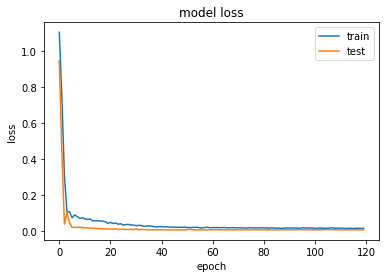

Test RMSE: 0.076
Test MSE: 0.006
Test MAE: 0.059


In [ ]:
# summarize history for loss
plt.plot(cnn_lstm_history.history['loss'])
plt.plot(cnn_lstm_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model_cnn_lstm.predict(X_valid_series_sub)

# calculate test errors: NRMSE,NMSE,NMAE
rmse = np.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(test_y, yhat)
print('Test MSE: %.3f' % mse)
MAE = mae(test_y, yhat)
print('Test MAE: %.3f' % MAE)



In [ ]:
# make a prediction
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
def descale(descaler, values):
    values_2d = np.array(test_y)[: ,np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()
#yhat = model.predict(test_X)
prediction_descaled = descale(descaler, yhat)
X_valid_series_sub = X_valid_series_sub.reshape((X_valid_series_sub.shape[0], 13))
inv_yhat = np.concatenate((yhat, X_valid_series_sub[:, -13:]), axis=1)
# invert scaling for forecast
inv_yhat = descaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, X_valid_series_sub[:, -13:]), axis=1)
inv_y = descaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

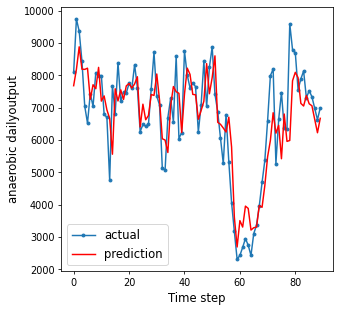

In [ ]:
# Prediction results visualization for CNN-LSTM
figure(figsize=(5, 5), dpi=70)
aa=[x for x in range(90)]
plt.plot(aa, inv_y[:90], marker='.', label="actual")
plt.plot(aa, inv_yhat[:90], 'r', label="prediction")
plt.ylabel('anaerobic dailyoutput', size=12)
plt.xlabel('Time step', size=12)
plt.legend(fontsize=12)
plt.show()